In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import model, train, metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
writer = SummaryWriter()

## Dataset

In [166]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [167]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [168]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [169]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [170]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


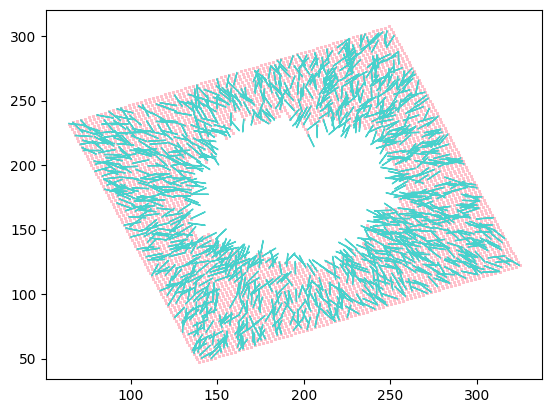

In [171]:
plotter.plot_train_data(train_data)

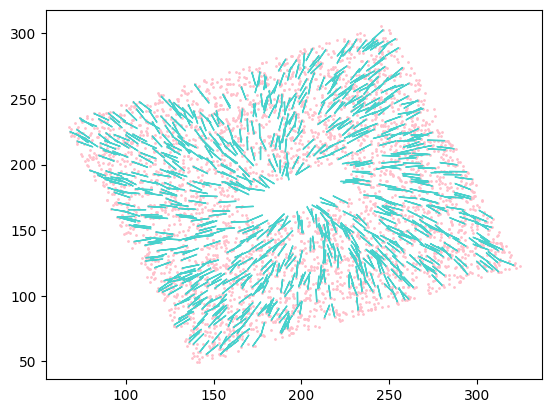

In [172]:
plotter.plot_data(val_data)

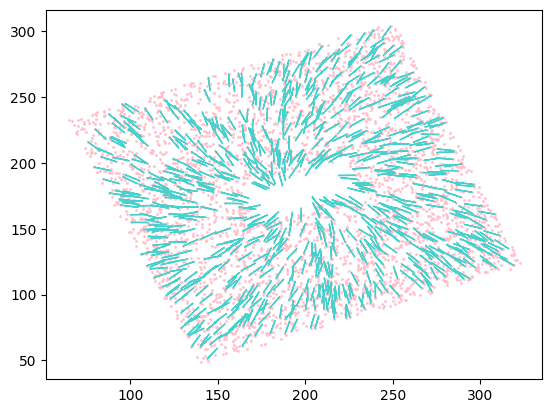

In [173]:
plotter.plot_data(test_data)

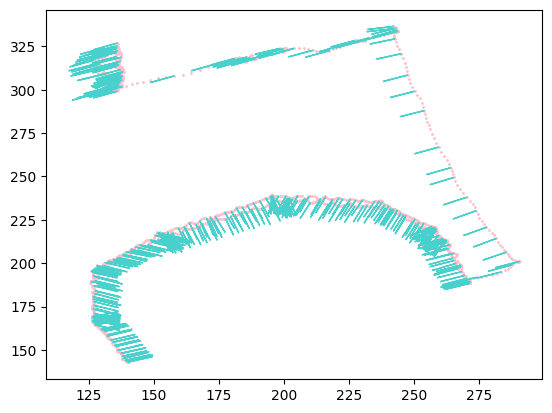

In [174]:
plotter.plot_data(real_data)

In [175]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


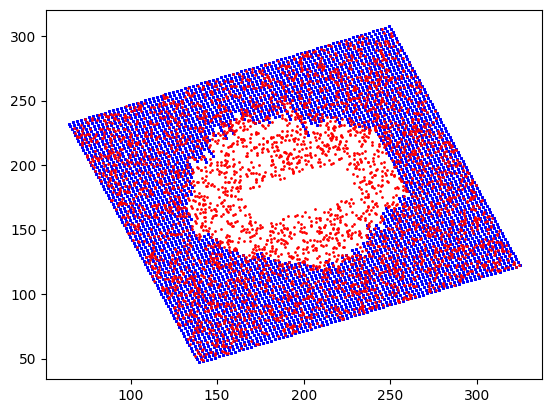

In [176]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2151.30it/s]


Validation after filtering: 3253


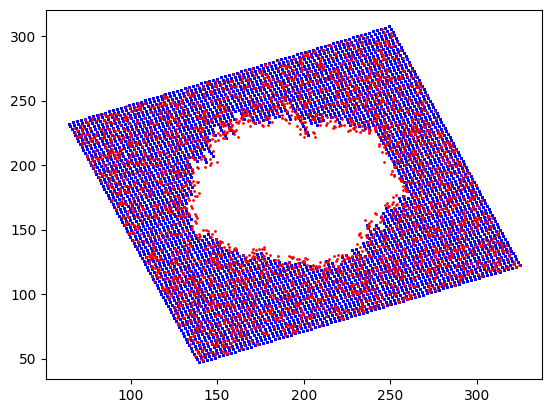

In [177]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


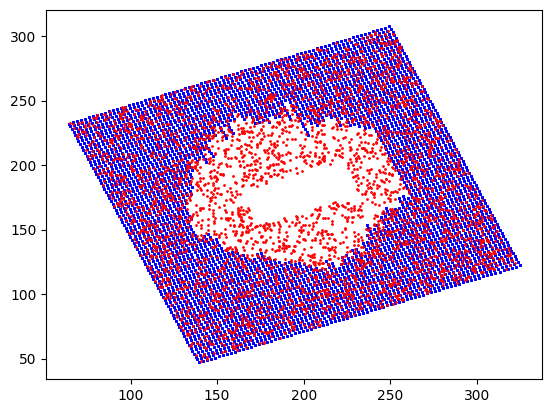

In [178]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2150.60it/s]


Test after filtering: 3271


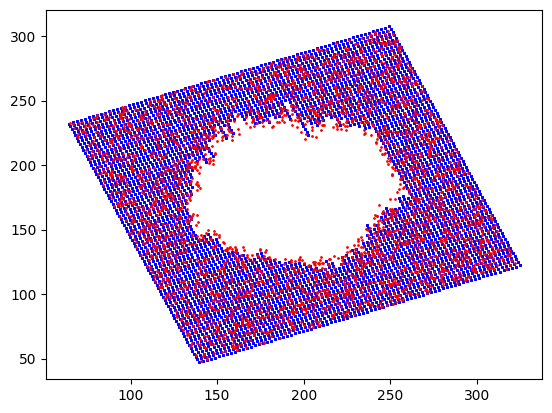

In [179]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

dist matrix tensor([1.7897, 1.7897, 1.7897, 1.7897, 1.7897])
cand tensor([187.9004, 202.9004, 172.9004, 217.9004, 232.9004])
yaw_deg 202.01324
diff yaw tensor([14.1129,  0.8871, 29.1129, 15.8871, 30.8871])
iou: 0.9564100080111195
yaw difference tensor(0.8871) deg
localization error:  0.17909636 meters


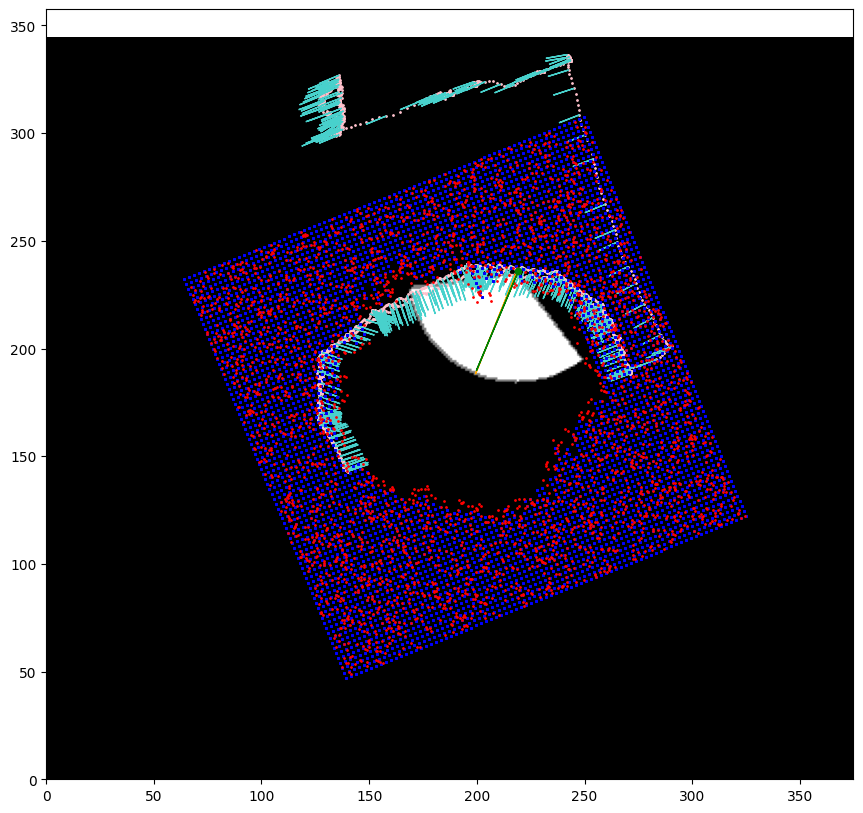

<Figure size 640x480 with 0 Axes>

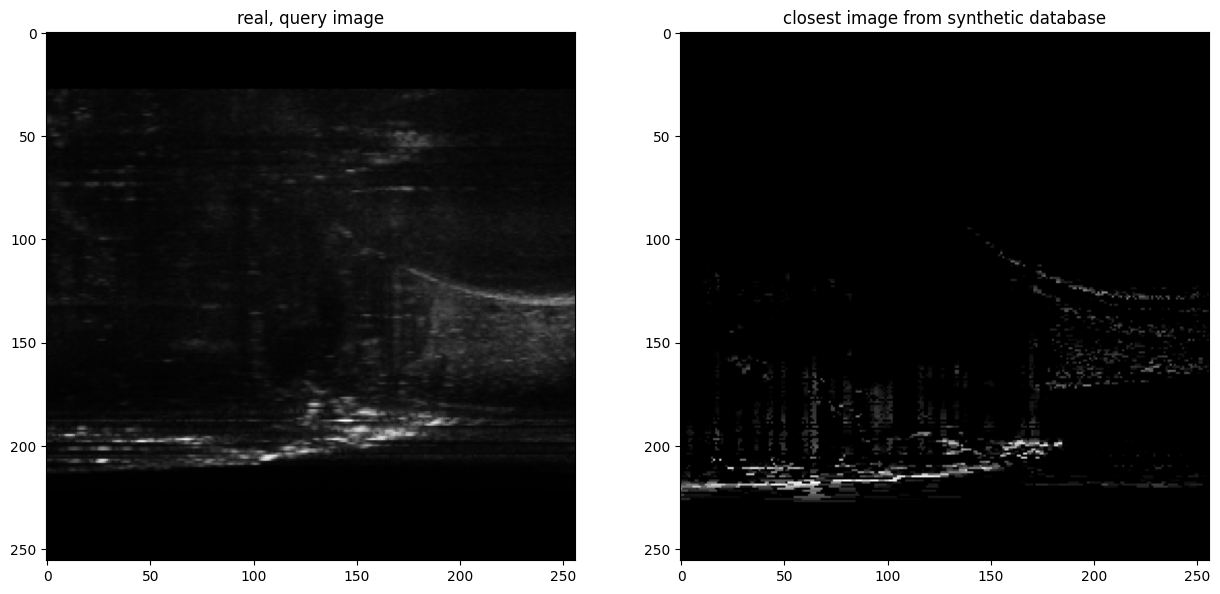

In [180]:
visualizer.localization(train_data, val_data, real_data)

In [181]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [182]:
val_data = visualizer.check_gt(train_data, val_data)

In [183]:
test_data = visualizer.check_gt(train_data, test_data)

In [184]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3268


In [185]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [186]:
net = model.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [187]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [25]:
train.train_epochs(writer, train_data, train_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)

100%|███████████████████████████████████████| 1501/1501 [23:48<00:00,  1.05it/s]


train loss mean: 5.388699678973116


100%|███████████████████████████████████████| 1501/1501 [23:47<00:00,  1.05it/s]


train loss mean: 0.005580674075421633


100%|███████████████████████████████████████| 1501/1501 [23:48<00:00,  1.05it/s]


train loss mean: 0.0040910068131874075


100%|███████████████████████████████████████| 1501/1501 [23:46<00:00,  1.05it/s]


train loss mean: 0.00558967019420745


100%|███████████████████████████████████████| 1501/1501 [23:47<00:00,  1.05it/s]


train loss mean: 0.005838189478206642


100%|███████████████████████████████████████| 1501/1501 [23:46<00:00,  1.05it/s]


train loss mean: 144951.95423542298


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]


train loss mean: 0.9651159349479015


100%|███████████████████████████████████████| 1501/1501 [23:43<00:00,  1.05it/s]


train loss mean: 0.3295469702799109


100%|███████████████████████████████████████| 1501/1501 [23:47<00:00,  1.05it/s]


train loss mean: 0.12865578027306834


100%|███████████████████████████████████████| 1501/1501 [23:43<00:00,  1.05it/s]


train loss mean: 0.05530299251523119


100%|███████████████████████████████████████| 1501/1501 [23:44<00:00,  1.05it/s]


train loss mean: 0.023538937909450434


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]


train loss mean: 0.00998911872750606


100%|███████████████████████████████████████| 1501/1501 [23:44<00:00,  1.05it/s]


train loss mean: 0.0054145485350736815


100%|███████████████████████████████████████| 1501/1501 [23:43<00:00,  1.05it/s]


train loss mean: 0.003575120804065728


100%|███████████████████████████████████████| 1501/1501 [23:43<00:00,  1.05it/s]


train loss mean: 0.002920644624136403


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]


train loss mean: 0.0027627847917492117


100%|███████████████████████████████████████| 1501/1501 [23:44<00:00,  1.05it/s]


train loss mean: 0.0028585068674275354


100%|███████████████████████████████████████| 1501/1501 [23:47<00:00,  1.05it/s]


train loss mean: 0.0034532846031657145


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]


train loss mean: 0.0026443262449865894


100%|███████████████████████████████████████| 1501/1501 [23:41<00:00,  1.06it/s]


train loss mean: 0.002595573534809306


100%|███████████████████████████████████████| 1501/1501 [23:44<00:00,  1.05it/s]


train loss mean: 0.0033486771790048903


100%|███████████████████████████████████████| 1501/1501 [23:42<00:00,  1.05it/s]


train loss mean: 0.003599805263665906


100%|███████████████████████████████████████| 1501/1501 [23:46<00:00,  1.05it/s]


train loss mean: 0.0042215824098655735


100%|███████████████████████████████████████| 1501/1501 [23:45<00:00,  1.05it/s]

train loss mean: 0.005071908962893623


In [188]:
metrics.get_descriptors(train_data, val_data, net)

100%|█████████████████████████████████████| 24005/24005 [04:19<00:00, 92.41it/s]


computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:23<00:00, 91.01it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:36<00:00, 90.09it/s]


descriptors computed!
torch.Size([3251]) torch.Size([3251, 5])
avg_metric_e     : tensor(74.7217)
avg_metric_e_top5: tensor(29.3476)


## Visualize Training results on Validation data

### Load the checkpoint model

In [189]:
checkpoint_path = f"correct_model_3/epoch_20.pth"
net = model.Model()
model.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [190]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:22<00:00, 91.36it/s]

descriptors computed!


In [191]:
val_data.computeDescriptors(net)

computing dataset descriptors


100%|███████████████████████████████████████| 3251/3251 [00:35<00:00, 90.43it/s]

descriptors computed!


### Visualize query results: sonar images

In [192]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-3.3720, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.4339, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-2.0232, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.2774, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-1.3961, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0006, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-3.0475, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.1353, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5220, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4301, device='cuda:0', grad_fn=<MaxBackward1>)


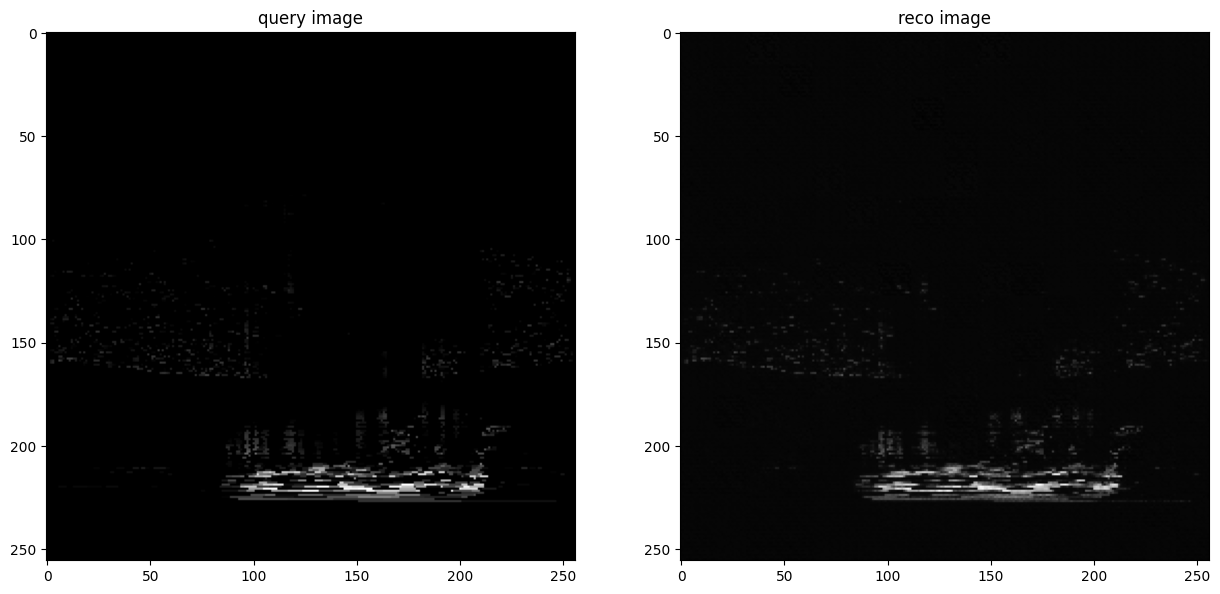

In [193]:
visualizer.analyze_feature_robustness(train_data, net)

dist matrix tensor([1.0232, 1.0232, 1.0232, 1.0232, 1.0232])
cand tensor([318.0452, 333.0452, 303.0452, 288.0452, 348.0452])
yaw_deg 328.1931838989258
diff yaw tensor([10.1480,  4.8520, 25.1480, 40.1480, 19.8520])
iou: 0.1416954939140078
localization error: 7.4035 meters
orientation error : 32.9277 degrees


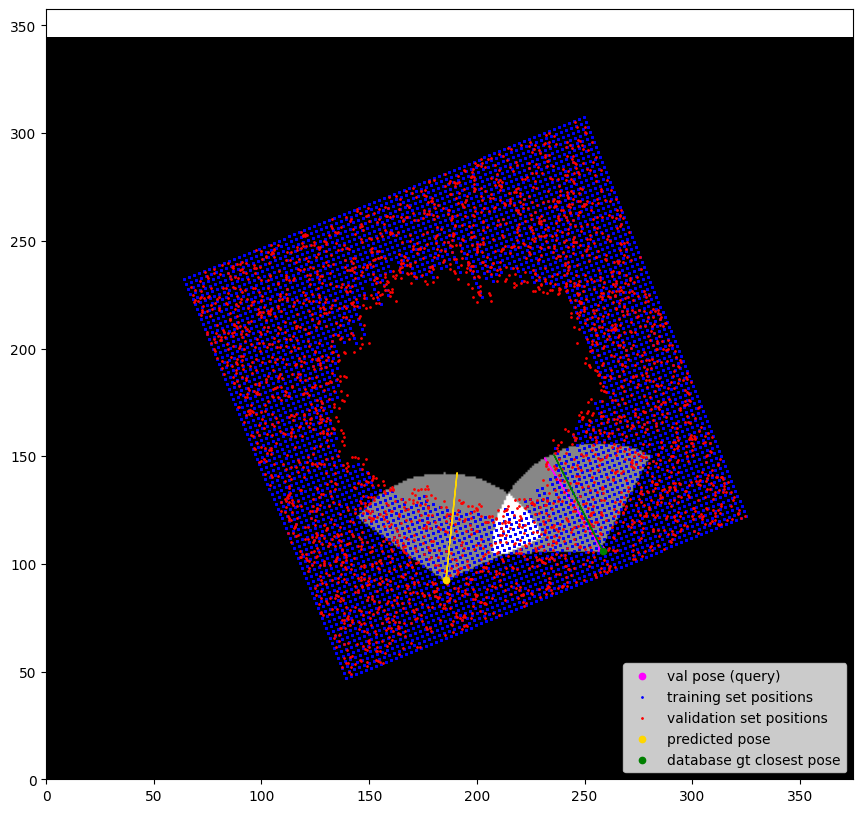

<Figure size 640x480 with 0 Axes>

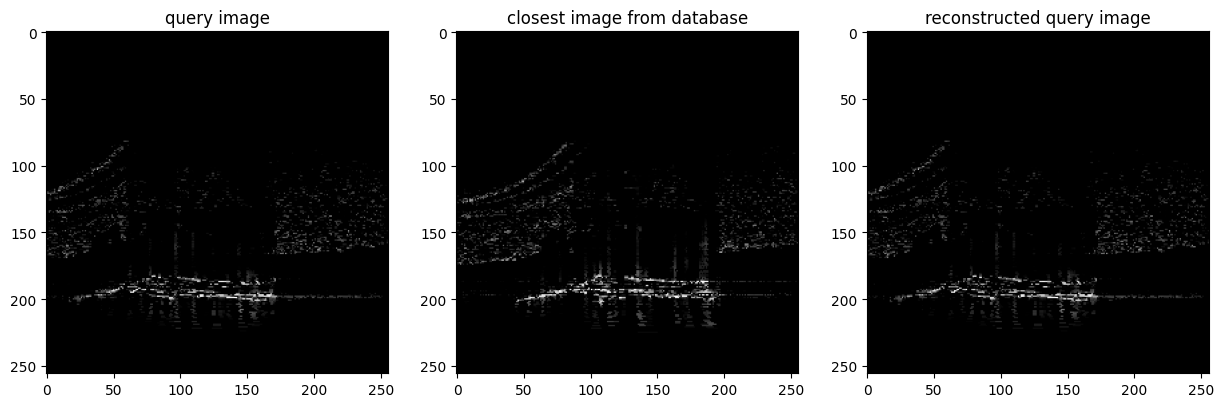

In [194]:
query_idx = random.randint(0, len(val_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [196]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(val_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|███████████████████████████████████████| 3251/3251 [06:31<00:00,  8.31it/s]

average localization error: 2.1444 meters
average orientation error : 15.3549 degrees


In [197]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [198]:
loca_errors.argmax()

np.int64(789)

In [199]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

1.4511378
9.025735


## Visualize Training results on Test data

### Load the checkpoint model

In [200]:
checkpoint_path = f"correct_model_3/epoch_20.pth"
net = model.Model()
model.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [201]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:15<00:00, 93.96it/s]

descriptors computed!


### Visualize query results: sonar images

In [202]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-3.3720, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.4339, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-2.0232, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.2774, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-1.3961, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0006, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-3.0475, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.1353, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5232, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4331, device='cuda:0', grad_fn=<MaxBackward1>)


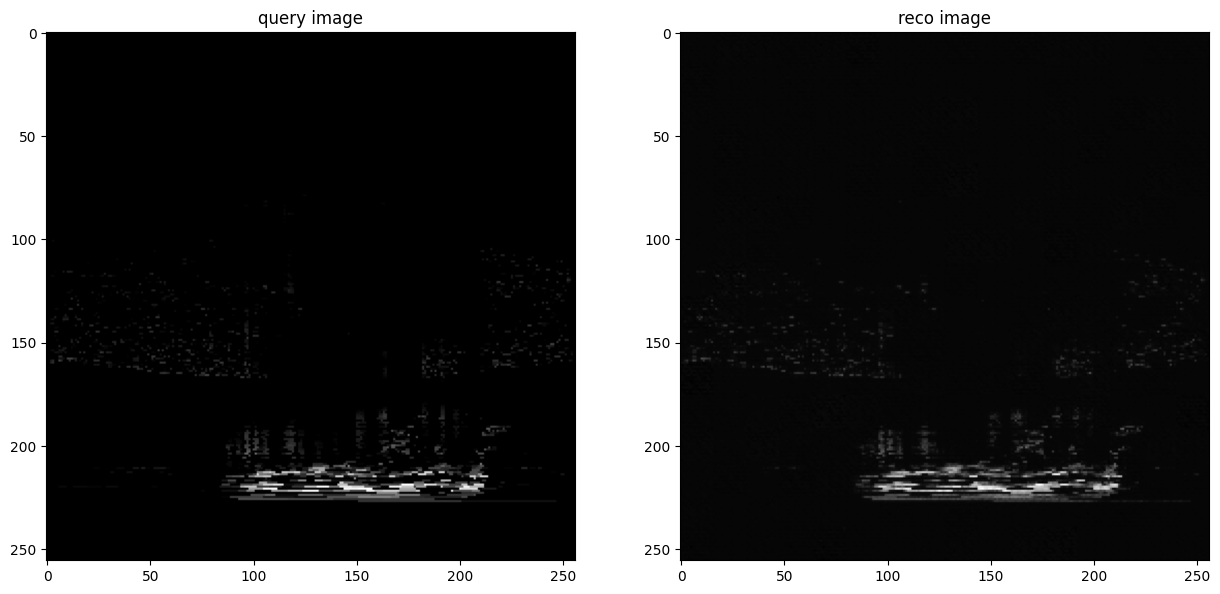

In [203]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.8112183811131191
localization error: 1.0000 meters
orientation error : 4.2364 degrees


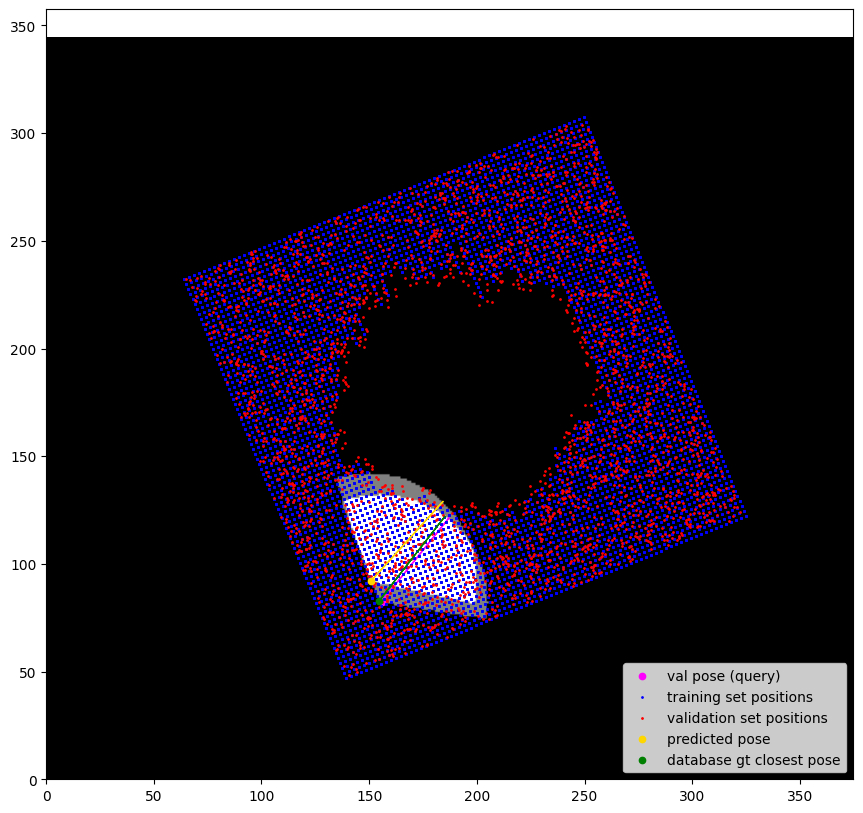

<Figure size 640x480 with 0 Axes>

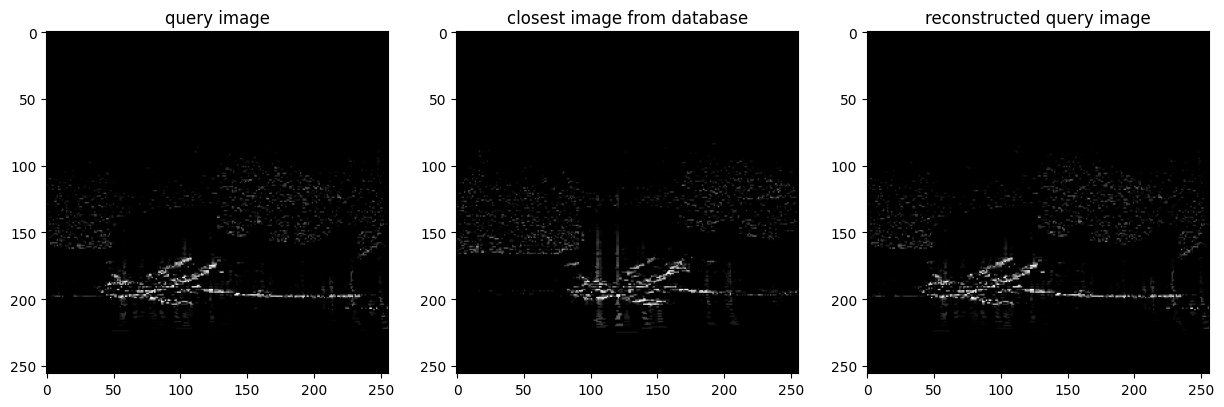

In [204]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [205]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

100%|███████████████████████████████████████| 3268/3268 [06:29<00:00,  8.38it/s]

average localization error: 2.1282 meters
average orientation error : 15.5152 degrees


In [206]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [207]:
loca_errors.argmax()

np.int64(2256)

In [208]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

1.4110779
8.904531


## process real images

query_idx: 133
196.57013 235.14008 2.842731 -17.12352
iou: 0.0
localization error Upper:  10.375771 meters


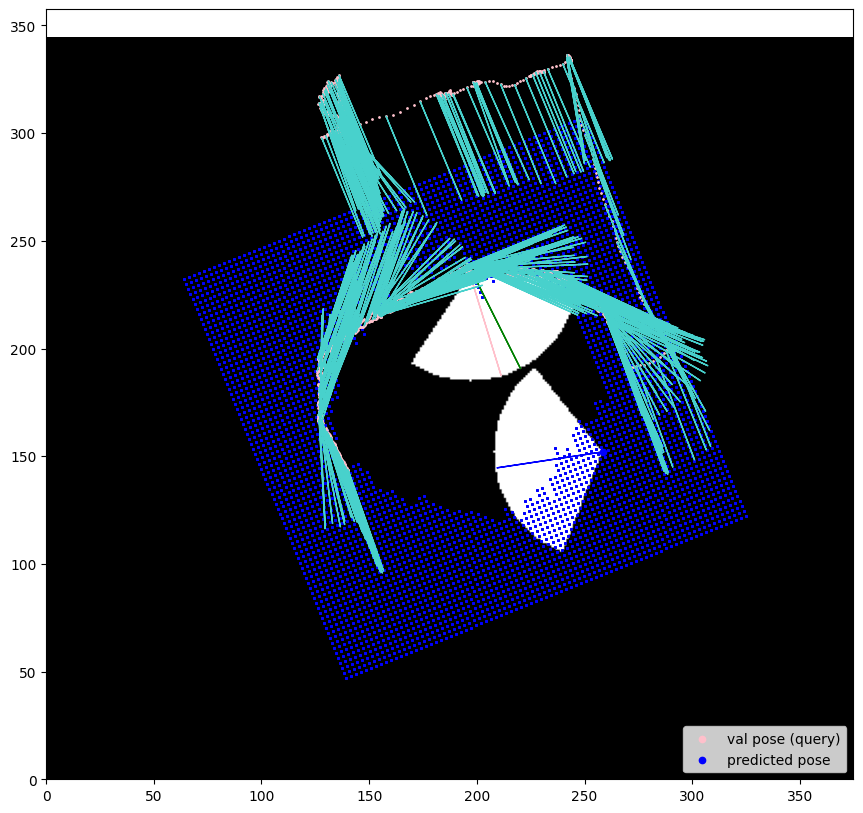

<Figure size 640x480 with 0 Axes>

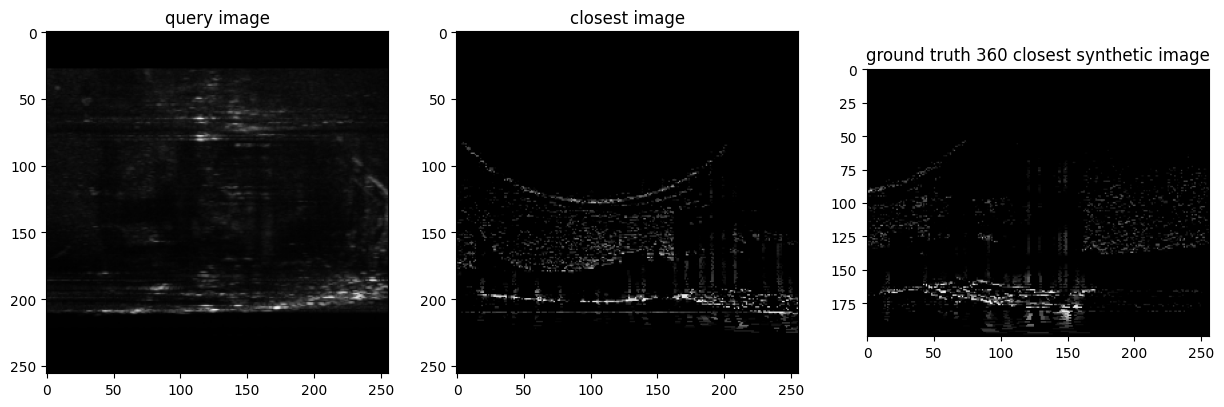

In [209]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [210]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [211]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:09<00:00, 78.78it/s]

descriptors computed!


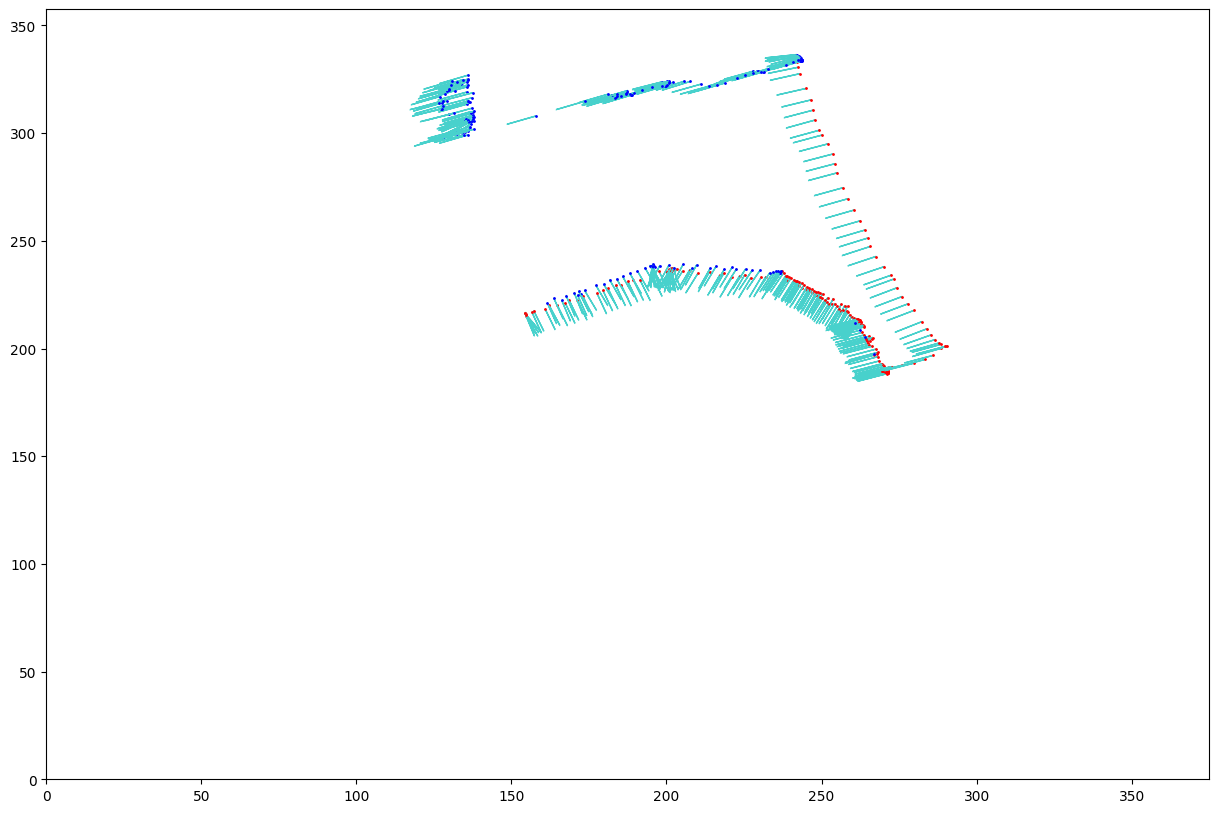

In [212]:
visualizer.visualize_real(train_data, real_data)

iou: 0.5827547074818871
localization error: 2.4348 meters
orientation error : 1.8392 degrees


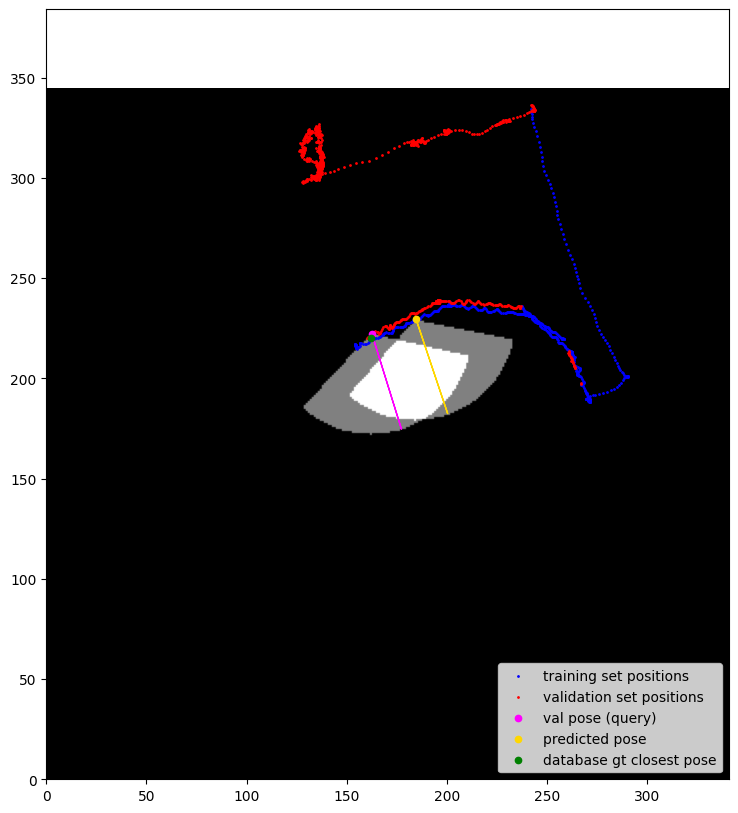

<Figure size 640x480 with 0 Axes>

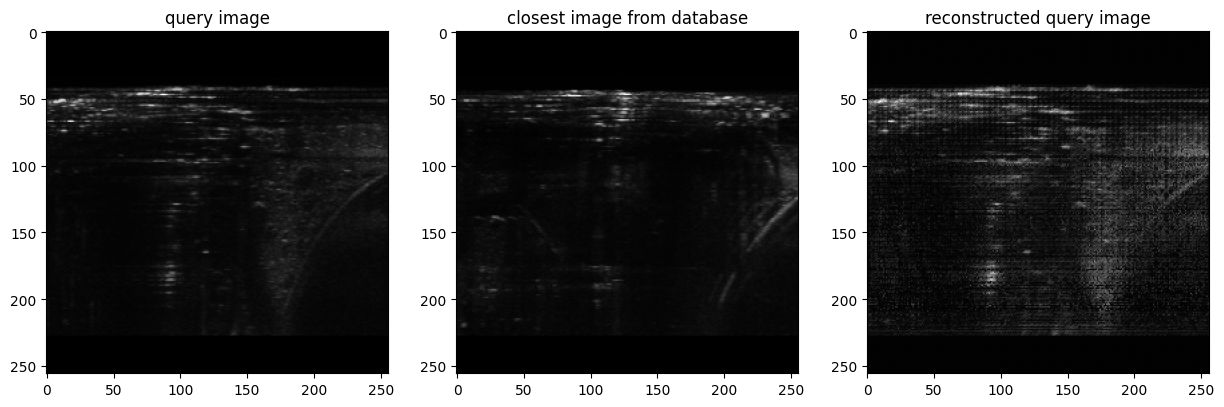

In [213]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  7%|███                                       | 57/785 [00:01<00:21, 33.10it/s]

In [ ]:
avg_orie_error.min()